# Convolutional Neural Networks (CNNs)

### Welcome to the 11th Lab of 42028: Deep Learning and CNN!

In this  Lab/Tutorial session you will be implementing simple ResNet50 module and create a Convolutional Neural Network for image classification .

So lets get started!

## Tutorial:
Implementation of Simple ResNet50 based Micro-ResNet CNN architecture using Keras for classfication of FashionMNIST dataset.

## Tasks for this week:

1. Implementation of Simple ResNet50 based Mini-ResNet CNN architecture for FashionMNIST image classification using Keras API.
2. Train and test model


**Reference and adapted from:** https://github.com/alinarw/ResNet/blob/master/ResNet.ipynb 

## The ResNet Begins !

### Step 1: Import required packages

we will need tensorflow, numpy, os and keras


In [1]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, BatchNormalization, Activation, Add

from keras.layers import MaxPooling2D, Input
from keras.initializers import glorot_uniform

import cv2 
import numpy as np 
from keras.datasets import cifar10, fashion_mnist 
from keras import backend as K 
from keras.utils import np_utils

from keras import backend as K
from keras.regularizers import l2

import math 
from keras.optimizers import SGD, Adam, Adadelta 
from keras.callbacks import LearningRateScheduler
from keras.activations import relu, softmax
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix

from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import HTML, display, clear_output, SVG

import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.


### Step-2: Design the Simple ResNet-50 module

<img src='http://drive.google.com/uc?export=view&id=1spP_NXWTUqJG-Mlw9VKC3jxpgCEriYCa' alt='Conv'> 




In [0]:
# Residual block conv(1X1) -> BN -> relu -> conv(3x3) -> bn -> relu -> conv(1x1) ->BN

def res_block(x, filters):

    print('Input Shape x.shape', x.shape)
    # Create 1X1 CONV, --> BatchNormalization --> Activation, Initialize weights with Xavier uniform initialization (glorot_uniform)
    conv1 = Conv2D(filters=filters, kernel_size=(1, 1), strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(x)
    bn1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(bn1)
    print('conv1.shape', conv1.shape)

    # Create 3X3 CONV, --> BatchNormalization --> Activation, Initialize weights with Xavier uniform initialization (glorot_uniform)
    conv2 = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act1)
    bn2 = BatchNormalization()(conv2)
    act2 = Activation('relu')(bn2)
    print('conv2.shape', conv2.shape)

    # Create 1X1 CONV, --> BatchNormalization, Initialize weights with Xavier uniform initialization (glorot_uniform)
    conv3 = Conv2D(filters=filters, kernel_size=(1, 1), strides=(1, 1), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act2)
    bn3 = BatchNormalization()(conv3)
    print('conv3.shape', conv3.shape)

    # Create 1X1 CONV on the Input to re-shape
    x = Conv2D(filters=filters, kernel_size=(1, 1), strides=(2, 2), padding='same')(x)

    out = Add()([bn3, x])
    
    return out

In [0]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

### Step 3: Design a Micro-ResNet with 1 Layer of Residual Block

<img src='http://drive.google.com/uc?export=view&id=1PITOPO_fNskYWDS6GEIGKJn-FItNuw_j' alt='Conv'>





In [4]:
# Define Images dimension and number of classes
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
num_classes = 10

# Create the input layer
input_layer = Input(shape=(img_rows, img_cols, 1)) # Use the actual input size

# Create 7X7X64 CONV --> BatchNormalization --> Activation 
x = Conv2D(64, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           )(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Add MaxPOOL, 3X3, Pad: Same, Stride: 2
x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)

# Add 1 ResNet block, 64 filter
res_block1 = res_block(x, 64)
print('---------block 1 end-----------')

# Create Classifier Block
# Add Flatten layer
classifer_Block = Flatten()(res_block1)

# Add Dense Layer, 1000 nodes, Activation - ReLU
classifer_Block = Dense(1000,
                activation='relu')(classifer_Block)

# Add Dense Layer, 10 nodes, Activation = SoftMax
outputs = Dense(num_classes,
                activation='softmax')(classifer_Block)

Input Shape x.shape (None, 7, 7, 64)
conv1.shape (None, 4, 4, 64)
conv2.shape (None, 4, 4, 64)
conv3.shape (None, 4, 4, 64)
---------block 1 end-----------


In [0]:
# Form the model
model = Model(input_layer, outputs, name='Micro_ResNet')

Model: "Micro_ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 14, 14, 64)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

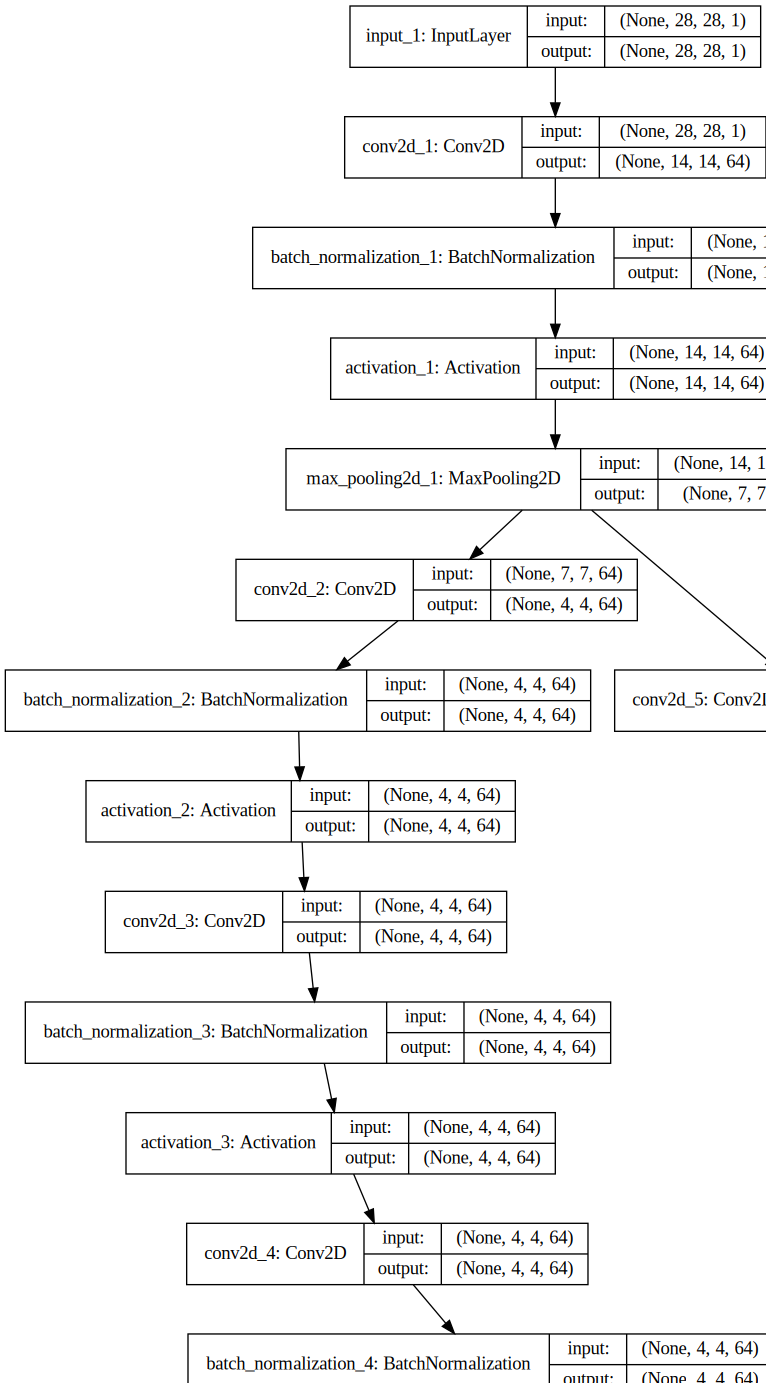

In [6]:
#Display Model Summary
model.summary()

plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True, rankdir='TB')
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

### Step 4: Download the Fashion-MNIST dataset using keras

In [0]:
num_classes = 10 #Number of classes in the dataset

def load_fashion_mnist_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = fashion_mnist.load_data()
    
    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

In [8]:
# Display the shapes of the training images
X_train, y_train, X_test, y_test = load_fashion_mnist_data(28, 28)
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


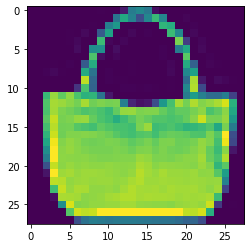

In [9]:
## Display an image from the dataset
import matplotlib.pyplot as plt
plt.imshow(X_train.reshape(X_train.shape[0], 28, 28)[100])

### Step 5: Define the Hyper-parameters, Compile the model, Start training

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [11]:
#Start training the model
history1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100)


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 12s 204us/step - loss: 0.4236 - accuracy: 0.8524 - val_loss: 0.3281 - val_accuracy: 0.8793
Epoch 2/15
60000/60000 [==============================] - 11s 176us/step - loss: 0.2749 - accuracy: 0.8978 - val_loss: 0.3092 - val_accuracy: 0.8904
Epoch 3/15
60000/60000 [==============================] - 10s 171us/step - loss: 0.2255 - accuracy: 0.9144 - val_loss: 0.3002 - val_accuracy: 0.8907
Epoch 4/15
60000/60000 [==============================] - 10s 173us/step - loss: 0.1915 - accuracy: 0.9273 - val_loss: 0.3502 - val_accuracy: 0.8793
Epoch 5/15
60000/60000 [==============================] - 10s 171us/step - loss: 0.1664 - accuracy: 0.9362 - val_loss: 0.3258 - val_accuracy: 0.8905
Epoch 6/15
60000/60000 [==============================] - 10s 170us/step - loss: 0.1349 - accuracy: 0.9492 - val_loss: 0.3883 - val_accuracy: 0.8854
Epoch 7/15
60000/60000 [==============================] 

### Step 6: Display Training and Validation accuracy curve

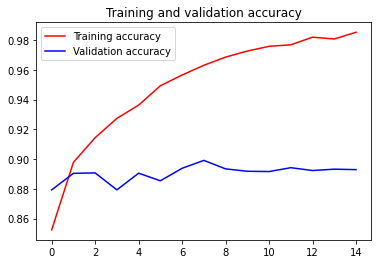

In [12]:
## Plot the Traning and Validation loss

loss = history1.history['accuracy']
val_loss = history1.history['val_accuracy']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

In [13]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 134us/step
Test loss: 0.5880491301447153
Test accuracy: 0.8928999900817871


## Your task begins now!

## Task 1: Design a Mini-ResNet 

### Add three ResNet50 layers in the Mico-ResNet architecture created above in the following order and configuration:

<img src='http://drive.google.com/uc?export=view&id=1nhCprmNy2MqGM2W4De_pP2-L2tk0K5uU' alt='Conv'>



In [14]:
# Define Images dimension and number of classes
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
num_classes = 10

# Create the input layer
input_layer = Input(shape=(img_rows, img_cols, 1)) # Use the actual input size

# Create 7X7X64 CONV --> BatchNormalization --> Activation 
x = Conv2D(64, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           )(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Add MaxPOOL, 3X3, Pad: Same, Stride: 2
x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)

# Add 3 ResNet block, 64 filter, 256 filters, and 512 filters
res_block1 = res_block(x, 64)
print('---------block 1 end-----------')
res_block2 = res_block(res_block1, 256)
print('---------block 2 end-----------')
res_block3 = res_block(res_block2, 512)
print('---------block 3 end-----------')

# Create Classifier Block
# Add Flatten layer
classifer_Block = Flatten()(res_block3)

# Add Dense Layer, 1000 nodes, Activation - ReLU
classifer_Block = Dense(1000,
                activation='relu')(classifer_Block)

# Add Dense Layer, 10 nodes, Activation = SoftMax
outputs = Dense(num_classes,
                activation='softmax')(classifer_Block)

Input Shape x.shape (None, 7, 7, 64)
conv1.shape (None, 4, 4, 64)
conv2.shape (None, 4, 4, 64)
conv3.shape (None, 4, 4, 64)
---------block 1 end-----------
Input Shape x.shape (None, 4, 4, 64)
conv1.shape (None, 2, 2, 256)
conv2.shape (None, 2, 2, 256)
conv3.shape (None, 2, 2, 256)
---------block 2 end-----------
Input Shape x.shape (None, 2, 2, 256)
conv1.shape (None, 1, 1, 512)
conv2.shape (None, 1, 1, 512)
conv3.shape (None, 1, 1, 512)
---------block 3 end-----------


In [0]:
# Form the Model
model = Model(input_layer, outputs, name='Mini-ResNet')

Model: "Mini-ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   3200        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 14, 14, 64)   256         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 14, 14, 64)   0           batch_normalization_5[0][0]      
________________________________________________________________________________________

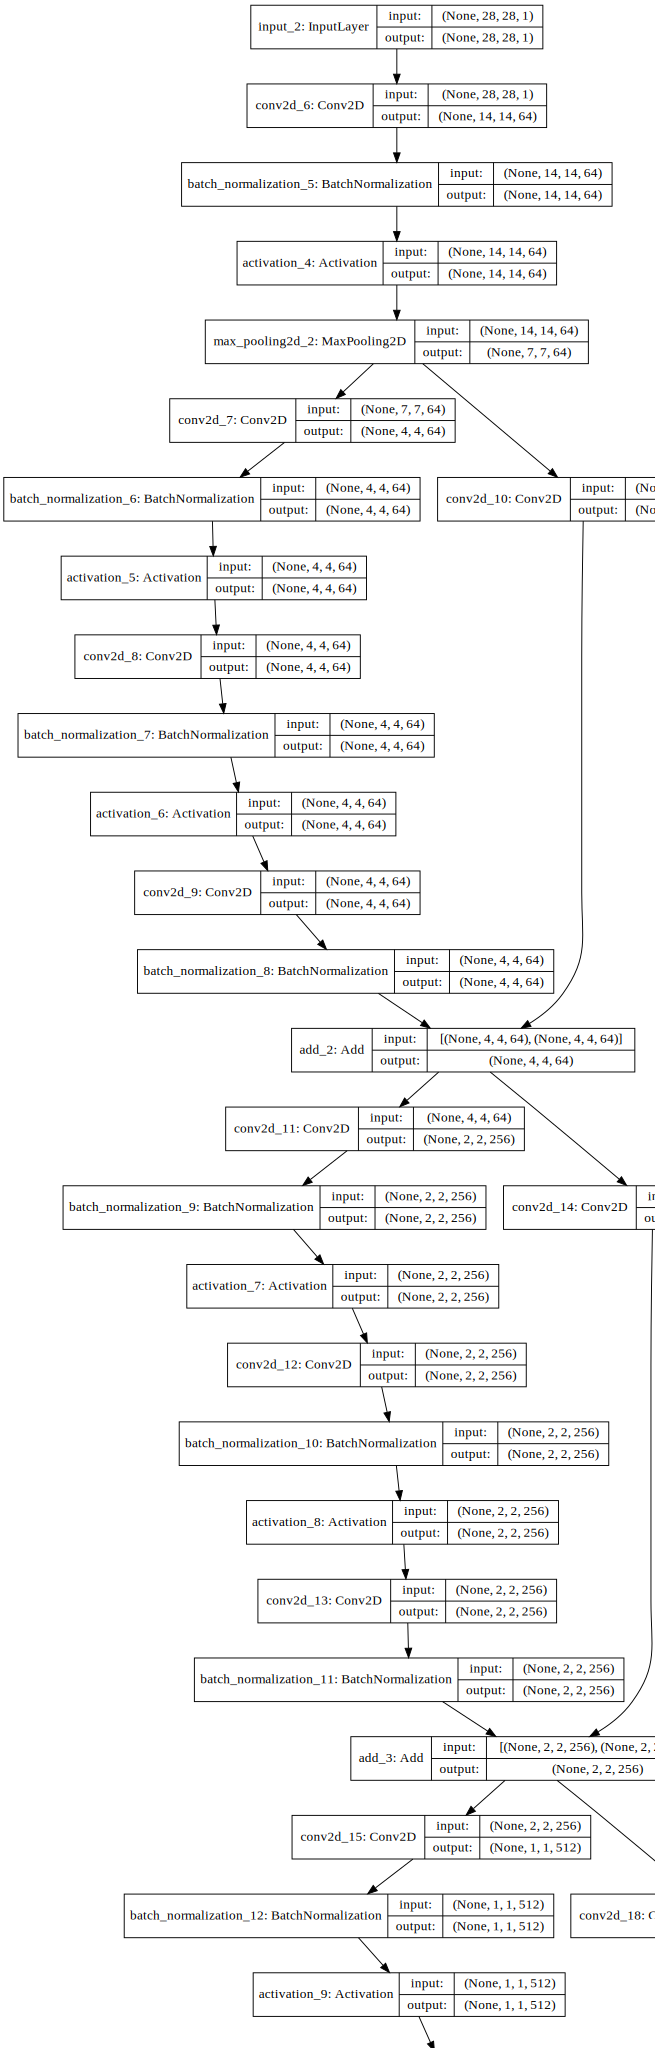

In [18]:
# Print Model Summary
model.summary()

plot_model(model, to_file='model2.png', show_layer_names=True, show_shapes=True, rankdir='TB')
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

## Task 2: Define the HyperParamenters, Optimzer, etc and compile model

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

## Task 3: Train the Model

In [21]:
#Start training the model
history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 26s 441us/step - loss: 0.4665 - accuracy: 0.8335 - val_loss: 0.4174 - val_accuracy: 0.8513
Epoch 2/15
60000/60000 [==============================] - 24s 393us/step - loss: 0.3250 - accuracy: 0.8806 - val_loss: 0.3698 - val_accuracy: 0.8682
Epoch 3/15
60000/60000 [==============================] - 24s 394us/step - loss: 0.2934 - accuracy: 0.8925 - val_loss: 0.3364 - val_accuracy: 0.8819
Epoch 4/15
60000/60000 [==============================] - 24s 395us/step - loss: 0.2698 - accuracy: 0.9009 - val_loss: 0.3354 - val_accuracy: 0.8803
Epoch 5/15
60000/60000 [==============================] - 24s 394us/step - loss: 0.2508 - accuracy: 0.9080 - val_loss: 0.3065 - val_accuracy: 0.8932
Epoch 6/15
60000/60000 [==============================] - 24s 393us/step - loss: 0.2367 - accuracy: 0.9131 - val_loss: 0.3153 - val_accuracy: 0.8932
Epoch 7/15
60000/60000 [==============================] 

## Task 4: Test on Train and Test set

In [22]:
# Test the model on Test and Validationa dataset
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 3s 263us/step


[0.3263441467225552, 0.9003999829292297]

## Task 5: Display the Train and Validation Accuracy curve

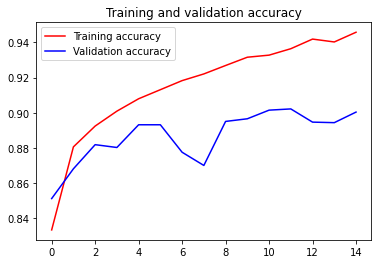

In [23]:
## Plot the Traning and Validation loss

loss = history2.history['accuracy']
val_loss = history2.history['val_accuracy']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()